https://teddylee777.github.io/tensorflow/LSTM%EC%9C%BC%EB%A1%9C-%EC%98%88%EC%B8%A1%ED%95%B4%EB%B3%B4%EB%8A%94-%EC%82%BC%EC%84%B1%EC%A0%84%EC%9E%90-%EC%A3%BC%EA%B0%80
 

# 삼성전자 주가 불러오기

In [1]:
#pip install yahoo-finance

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [2]:
df_price = pd.read_csv('C:/Users/병현/Downloads/01-삼성전자-주가.csv')
df_price.head()

,일자,시가,고가,저가,종가,거래량
0,20200107,55700,56400,55600,55800,9893846
1,20200106,54900,55600,54600,55500,10278951
2,20200103,56000,56600,54900,55500,15422255
3,20200102,55500,56000,55000,55200,12993228
4,20191230,56200,56600,55700,55800,8356767


In [3]:
df_price['일자'] = pd.to_datetime(df_price['일자'], format='%Y%m%d')
df_price

,일자,시가,고가,저가,종가,거래량
0,2020-01-07,55700,56400,55600,55800,9893846
1,2020-01-06,54900,55600,54600,55500,10278951
2,2020-01-03,56000,56600,54900,55500,15422255
3,2020-01-02,55500,56000,55000,55200,12993228
4,2019-12-30,56200,56600,55700,55800,8356767
...,...,...,...,...,...,...
9283,1985-01-09,126,126,122,123,324836
9284,1985-01-08,129,129,127,127,845098
9285,1985-01-07,129,130,128,129,771895
9286,1985-01-05,129,129,128,128,108496


In [4]:
df_price = (df_price.sort_values(by='일자').reset_index()).drop('index', axis= 1)
df_price

,일자,시가,고가,저가,종가,거래량
0,1985-01-04,130,130,129,129,111764
1,1985-01-05,129,129,128,128,108496
2,1985-01-07,129,130,128,129,771895
3,1985-01-08,129,129,127,127,845098
4,1985-01-09,126,126,122,123,324836
...,...,...,...,...,...,...
9283,2019-12-30,56200,56600,55700,55800,8356767
9284,2020-01-02,55500,56000,55000,55200,12993228
9285,2020-01-03,56000,56600,54900,55500,15422255
9286,2020-01-06,54900,55600,54600,55500,10278951


In [5]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scale_cols = ['시가', '고가', '저가',  '거래량','종가']
df_scaled = scaler.fit_transform(df_price[scale_cols])

df_scaled = pd.DataFrame(df_scaled)
df_scaled.columns = scale_cols

df_scaled.head()


,시가,고가,저가,거래량,종가
0,0.000244,0.000244,0.000247,0.000342,0.000228
1,0.000227,0.000226,0.000229,0.000332,0.000210
2,0.000227,0.000244,0.000229,0.002363,0.000228
3,0.000227,0.000226,0.000212,0.002587,0.000193
4,0.000174,0.000174,0.000124,0.000995,0.000123


In [6]:
df_scaled['종가'] = df_price['종가'].values
df_scaled.head()

,시가,고가,저가,거래량,종가
0,0.000244,0.000244,0.000247,0.000342,129
1,0.000227,0.000226,0.000229,0.000332,128
2,0.000227,0.000244,0.000229,0.002363,129
3,0.000227,0.000226,0.000212,0.002587,127
4,0.000174,0.000174,0.000124,0.000995,123


- 종가 시각화

Text(0, 0.5, 'price')

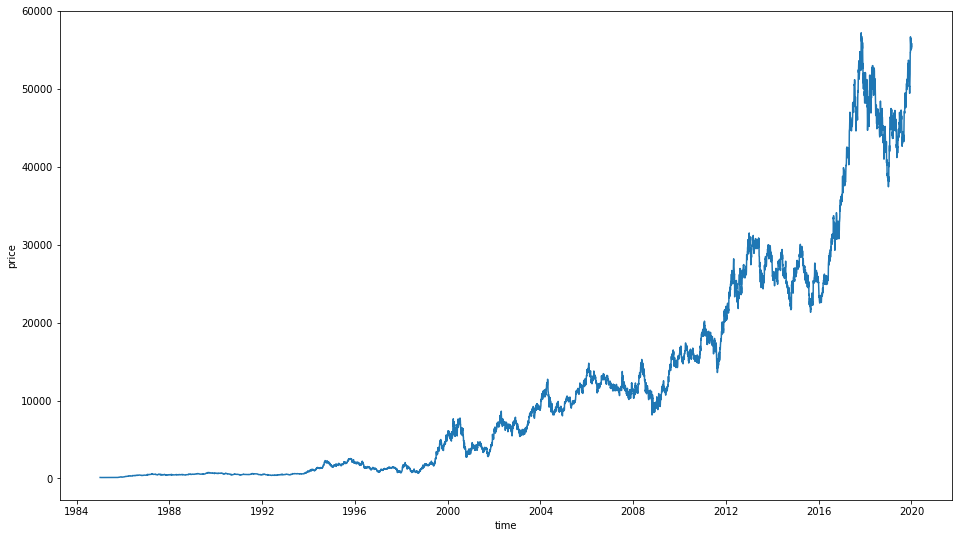

In [7]:
plt.figure(figsize=(16, 9))
sns.lineplot(y=df_price['종가'], x=df_price['일자'])
plt.xlabel('time')
plt.ylabel('price')

In [8]:
window_size=20  
TEST_SIZE = 200 #학습은 과거부터 200일 이전의 데이터를 학습하게 되고, TEST를 위해서 이후 200일의 데이터로 모델이 주가를 예측하도록함

>- 20일 동안의 데이터를 기반으로 참고하겠다 .
>- 학습은 과거부터 200일 이전의 데이터를 학습하게 되고, TEST를 위해서 이후 200일의 데이터로 모델이 주가를 예측하도록함

In [9]:
train = df_scaled[:-TEST_SIZE]
test = df_scaled[-TEST_SIZE:]

print(train.shape)
print(test.shape)

(9088, 5)
(200, 5)


### 아래 함수를 통해 , 20일기간의 데이터셋을 묶어주는 과정을 진행함
>- 가장 중요한 핵심과정
>- 20일 내의 값들이 output값에 영향을 미치도록 만들어주는 함수

In [10]:
def make_dataset(data, label, window_size=20):
    feature_list = []
    label_list = []
    
    for i in range(len(data) - window_size):
        feature_list.append(np.array(data.iloc[i:i+window_size]))
        label_list.append(np.array(label.iloc[i+window_size]))
    

    # 이 과정은 위 for문에서 생기는 20일치 공백기를 해결해주는 과정. 
    for j in range(len(data) - window_size , len(data)):
        feature_list.append(np.array(data.iloc[j-window_size: j]))
        label_list.append(np.array(label.iloc[j]))
    
    
    feature_list = np.array(feature_list)
    label_list = np.array(label_list)
    return feature_list, label_list


## 20일의 공백을 채워주는 과정이 필요함..

### feature과 label의 정의 

In [11]:
feature_cols = ['시가', '고가', '저가', '거래량']
label_cols = ['종가']

In [12]:
train_feature = train[feature_cols]
train_label = train[label_cols]

train_feature

,시가,고가,저가,거래량
0,0.000244,0.000244,0.000247,0.000342
1,0.000227,0.000226,0.000229,0.000332
2,0.000227,0.000244,0.000229,0.002363
3,0.000227,0.000226,0.000212,0.002587
4,0.000174,0.000174,0.000124,0.000995
...,...,...,...,...
9083,0.769971,0.781026,0.777385,0.035001
9084,0.769099,0.772316,0.769441,0.024825
9085,0.759515,0.769702,0.766793,0.055229
9086,0.761257,0.768831,0.769441,0.051479


### 위에서 생성한 함수를 통해 , train dataset 변환시켜줌 

In [13]:
train_feature, train_label = make_dataset(train_feature, train_label, 20)
print(train_feature.shape)
print(train_label.shape)

(9088, 20, 4)
(9088, 1)


In [14]:
# train, validation set 생성
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(train_feature, train_label, test_size=0.2)

print(X_train.shape , y_train.shape)
print(X_valid.shape , y_valid.shape)

(7270, 20, 4) (7270, 1)
(1818, 20, 4) (1818, 1)


### test 데이터셋 

In [15]:
test_feature = test[feature_cols]
test_label = test[label_cols]

In [16]:
test_feature, test_label = make_dataset(test_feature, test_label, 20)
test_feature.shape, test_label.shape

((200, 20, 4), (200, 1))

In [17]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import LSTM

model = Sequential()
model.add(LSTM(16,
               input_shape=(train_feature.shape[1], train_feature.shape[2]), 
               activation='relu', 
               return_sequences=False)
          )
model.add(Dense(1))

In [18]:

model.compile(loss='mean_squared_error', optimizer='adam')
early_stop = EarlyStopping(monitor='val_loss', patience=5)
#filename = os.path.join(model_path, 'tmp_checkpoint.h5')
#checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

history = model.fit(X_train, y_train, 
                    epochs=200, 
                    batch_size=32,
                    validation_data=(X_valid, y_valid), 
                    callbacks=[early_stop])

Train on 7270 samples, validate on 1818 samples
Epoch 1/200
7270/7270 [==============================] - 5s 655us/sample - loss: 109542807.0564 - val_loss: 6090123.9906
Epoch 2/200
7270/7270 [==============================] - 3s 401us/sample - loss: 5158982.4177 - val_loss: 3317271.6290
Epoch 3/200
7270/7270 [==============================] - 3s 399us/sample - loss: 2163719.4647 - val_loss: 1809896.1403ss:  - ETA: 0s - loss: 22219 - ETA: 0s - loss: 2187927.8
Epoch 4/200
7270/7270 [==============================] - 3s 404us/sample - loss: 1664723.2698 - val_loss: 1617201.2221
Epoch 5/200
7270/7270 [==============================] - 3s 385us/sample - loss: 1407796.0211 - val_loss: 1272769.9971
Epoch 6/200
7270/7270 [==============================] - 3s 379us/sample - loss: 1418697.8909 - val_loss: 1705869.2794
Epoch 7/200
7270/7270 [==============================] - 3s 368us/sample - loss: 1516600.4132 - val_loss: 1210897.8613
Epoch 8/200
7270/7270 [==============================] - 3s 3

In [19]:
test_feature[:5][0]

array([[0.76038617, 0.7627343 , 0.76679319, 0.02329777],
       [0.76125749, 0.76796042, 0.75884897, 0.03014568],
       [0.77519866, 0.80367222, 0.77562009, 0.06471706],
       [0.8144082 , 0.81673751, 0.81445847, 0.03838049],
       [0.78739718, 0.79321998, 0.78886045, 0.02663546],
       [0.79088248, 0.794091  , 0.79062583, 0.02978921],
       [0.77781263, 0.79234897, 0.77915085, 0.02929405],
       [0.78129792, 0.78538081, 0.78003354, 0.0208844 ],
       [0.77345602, 0.78015469, 0.77826816, 0.03518352],
       [0.78565454, 0.78973591, 0.78974314, 0.02254021],
       [0.7917538 , 0.80105916, 0.79857004, 0.02902648],
       [0.81266555, 0.81238241, 0.80651426, 0.03807634],
       [0.80220968, 0.81847955, 0.81269309, 0.0387303 ],
       [0.81615084, 0.82631872, 0.8206373 , 0.02616584],
       [0.82137878, 0.82109261, 0.81269309, 0.02604818],
       [0.81179423, 0.81586649, 0.81357578, 0.02106031],
       [0.80656629, 0.81151139, 0.81092771, 0.03638455],
       [0.81179423, 0.81325343,

In [20]:
df_price.loc[9088:9100]

,일자,시가,고가,저가,종가,거래량
9088,2019-03-19,43750,43900,43550,43900,7609563
9089,2019-03-20,43800,44200,43100,44050,9846242
9090,2019-03-21,44600,46250,44050,45850,21138016
9091,2019-03-22,46850,47000,46250,46550,12535911
9092,2019-03-25,45300,45650,44800,45500,8699728
9093,2019-03-26,45500,45700,44900,45250,9729811
9094,2019-03-27,44750,45600,44250,45350,9568081
9095,2019-03-28,44950,45200,44300,44850,6821306
9096,2019-03-29,44500,44900,44200,44650,11491713
9097,2019-04-01,45200,45450,44850,45050,7362129


In [21]:
test[:20]

,시가,고가,저가,거래량,종가
9088,0.760386,0.762734,0.766793,0.023298,43900
9089,0.761257,0.767960,0.758849,0.030146,44050
9090,0.775199,0.803672,0.775620,0.064717,45850
9091,0.814408,0.816738,0.814458,0.038380,46550
9092,0.787397,0.793220,0.788860,0.026635,45500
9093,0.790882,0.794091,0.790626,0.029789,45250
9094,0.777813,0.792349,0.779151,0.029294,45350
9095,0.781298,0.785381,0.780034,0.020884,44850
9096,0.773456,0.780155,0.778268,0.035184,44650
9097,0.785655,0.789736,0.789743,0.022540,45050


In [22]:
df_price.loc[9088:9100]

,일자,시가,고가,저가,종가,거래량
9088,2019-03-19,43750,43900,43550,43900,7609563
9089,2019-03-20,43800,44200,43100,44050,9846242
9090,2019-03-21,44600,46250,44050,45850,21138016
9091,2019-03-22,46850,47000,46250,46550,12535911
9092,2019-03-25,45300,45650,44800,45500,8699728
9093,2019-03-26,45500,45700,44900,45250,9729811
9094,2019-03-27,44750,45600,44250,45350,9568081
9095,2019-03-28,44950,45200,44300,44850,6821306
9096,2019-03-29,44500,44900,44200,44650,11491713
9097,2019-04-01,45200,45450,44850,45050,7362129


In [23]:
df_price

,일자,시가,고가,저가,종가,거래량
0,1985-01-04,130,130,129,129,111764
1,1985-01-05,129,129,128,128,108496
2,1985-01-07,129,130,128,129,771895
3,1985-01-08,129,129,127,127,845098
4,1985-01-09,126,126,122,123,324836
...,...,...,...,...,...,...
9283,2019-12-30,56200,56600,55700,55800,8356767
9284,2020-01-02,55500,56000,55000,55200,12993228
9285,2020-01-03,56000,56600,54900,55500,15422255
9286,2020-01-06,54900,55600,54600,55500,10278951


In [24]:
pred = model.predict(test_feature)

In [25]:
train_feature.shape

(9088, 20, 4)

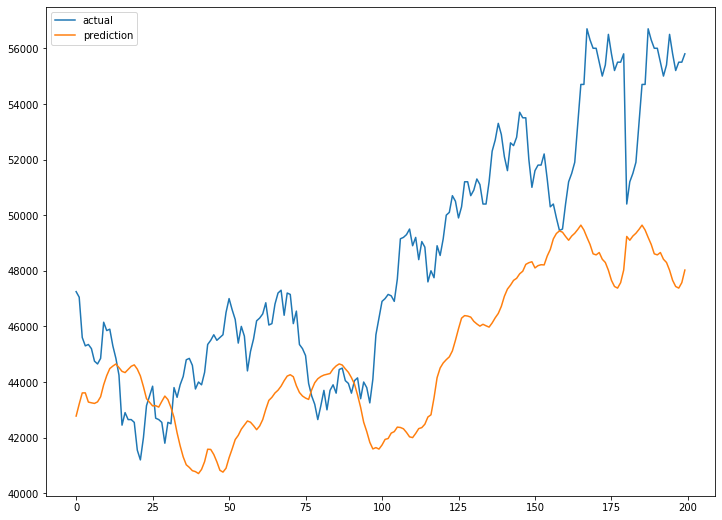

In [26]:
plt.figure(figsize=(12, 9))
plt.plot(test_label, label='actual')
plt.plot(pred, label='prediction')
plt.legend()
plt.show()

In [27]:
train_label[-10:]

array([[44250],
       [44000],
       [44450],
       [43800],
       [43650],
       [44650],
       [43850],
       [43850],
       [44200],
       [43700]], dtype=int64)

In [28]:
test_label

array([[47250],
       [47050],
       [45600],
       [45300],
       [45350],
       [45200],
       [44750],
       [44650],
       [44850],
       [46150],
       [45850],
       [45900],
       [45300],
       [44850],
       [44250],
       [42450],
       [42900],
       [42650],
       [42650],
       [42550],
       [41550],
       [41200],
       [42000],
       [43150],
       [43500],
       [43850],
       [42700],
       [42650],
       [42550],
       [41800],
       [42550],
       [42500],
       [43800],
       [43450],
       [43900],
       [44200],
       [44800],
       [44850],
       [44600],
       [43750],
       [44000],
       [43900],
       [44350],
       [45350],
       [45500],
       [45700],
       [45500],
       [45600],
       [45700],
       [46500],
       [47000],
       [46600],
       [46250],
       [45400],
       [46000],
       [45650],
       [44400],
       [45100],
       [45550],
       [46200],
       [46300],
       [46450],
       [

>- 비교적 정확하진 않지만 , 단순히 시계열을 활용한 LSTM 공부를 이해하는데에 많은 도움이 되었음